In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/conll003-englishversion/valid.txt
/kaggle/input/conll003-englishversion/metadata
/kaggle/input/conll003-englishversion/test.txt
/kaggle/input/conll003-englishversion/train.txt


In [2]:
from sklearn.metrics import confusion_matrix, classification_report
import itertools
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, GRU, LSTM, Dense, Bidirectional, TimeDistributed
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

2024-05-06 00:28:23.636188: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-06 00:28:23.636311: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-06 00:28:23.894958: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
def load_data(file_path):
    with open(file_path, "r") as f:
        lines = f.readlines()
        

    sentences, labels = [], []
    sentence, label = [], []

    for line in lines:
        if line == "\n" or line.startswith("-DOCSTART-"):
            if sentence and label:
                sentences.append(sentence)
                labels.append(label)
                sentence, label = [], []
        else:
            word, _, _, tag = line.strip().split()
            sentence.append(word.lower())  # Normalize the case
            label.append(tag)

    return sentences, labels

train_file_path = "../input/conll003-englishversion/train.txt"
valid_file_path= "../input/conll003-englishversion/valid.txt"
test_file_path = "../input/conll003-englishversion/test.txt"

train_sentences, train_labels = load_data(train_file_path)
valid_sentences, valid_labels = load_data(valid_file_path)
test_sentences, test_labels = load_data(test_file_path)

In [4]:
df = pd.DataFrame({
    "train_sentences":train_sentences,
    "train_labels":train_labels
})
df

,train_sentences,train_labels
0,"[eu, rejects, german, call, to, boycott, briti...","[B-ORG, O, B-MISC, O, O, O, B-MISC, O, O]"
1,"[peter, blackburn]","[B-PER, I-PER]"
2,"[brussels, 1996-08-22]","[B-LOC, O]"
3,"[the, european, commission, said, on, thursday...","[O, B-ORG, I-ORG, O, O, O, O, O, O, B-MISC, O,..."
4,"[germany, 's, representative, to, the, europea...","[B-LOC, O, O, O, O, B-ORG, I-ORG, O, O, O, B-P..."
...,...,...
14036,"[on, friday, :]","[O, O, O]"
14037,"[division, two]","[O, O]"
14038,"[plymouth, 2, preston, 1]","[B-ORG, O, B-ORG, O]"
14039,"[division, three]","[O, O]"


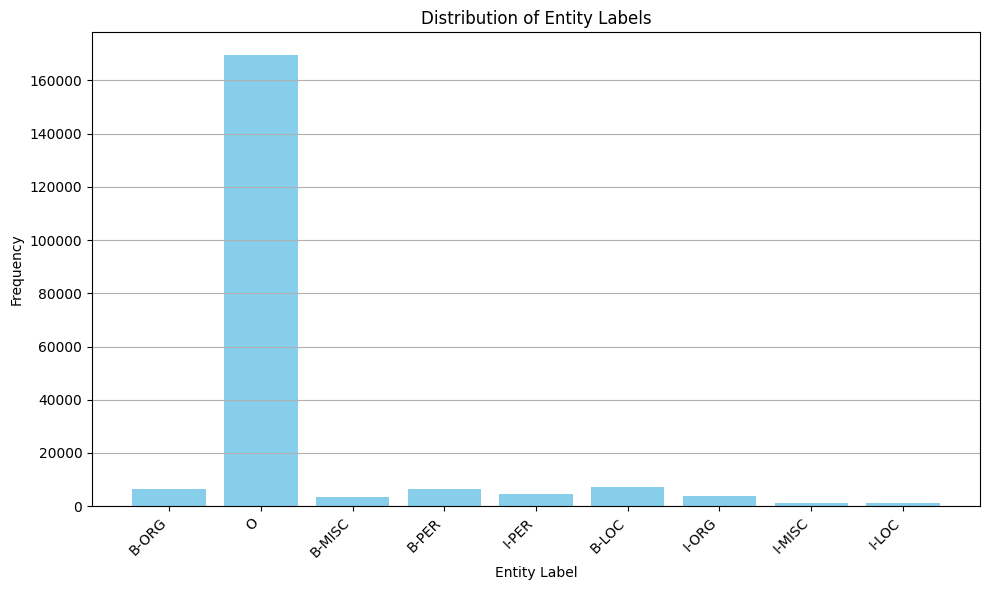

In [74]:
import matplotlib.pyplot as plt
from collections import Counter

# Flatten the list of labels
all_labels = [label for labels in train_labels for label in labels]

# Count the frequency of each label
label_counts = Counter(all_labels)

# Extract label names and their frequencies
labels = list(label_counts.keys())
frequencies = list(label_counts.values())

# Plot the distribution of entity labels
plt.figure(figsize=(10, 6))
plt.bar(labels, frequencies, color='skyblue')
plt.xlabel('Entity Label')
plt.ylabel('Frequency')
plt.title('Distribution of Entity Labels')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


In [73]:
train_sentences[0]

['eu', 'rejects', 'german', 'call', 'to', 'boycott', 'british', 'lamb', '.']

In [5]:
# Tokenize text
word2idx = {word: idx + 1 for idx, word in 
            enumerate(set(word for sentence in train_sentences 
                          for word in sentence))}
tag2idx = {tag: idx for idx, tag in enumerate(set(tag for labels in train_labels 
                                                  for tag in labels))}
max_len = max(len(sentence) for sentence in train_sentences)

In [6]:
word2idx

{'taste': 1,
 'edge': 2,
 'kickoff': 3,
 '165,150': 4,
 'southampton': 5,
 'schering': 6,
 'mulholland': 7,
 'concentrate': 8,
 'batty': 9,
 '12-mth': 10,
 'harb': 11,
 'big-serving': 12,
 'installations': 13,
 'mixture': 14,
 'al-muntar': 15,
 'mth': 16,
 'finances': 17,
 'oilfield': 18,
 'na': 19,
 'ownership': 20,
 'jonty': 21,
 'bedtime': 22,
 'americans': 23,
 'kivu': 24,
 '20th': 25,
 '43-month': 26,
 '45,020,000': 27,
 'valid': 28,
 'lawyer': 29,
 'massively': 30,
 '115,941': 31,
 'either': 32,
 'profiles': 33,
 'milenko': 34,
 'bureaucracy': 35,
 'unc': 36,
 'posts': 37,
 'accomplices': 38,
 'maoists': 39,
 'niclas': 40,
 'option': 41,
 'a.l.': 42,
 'identified': 43,
 'recaptured': 44,
 'ashley': 45,
 '1974': 46,
 '10-year-old': 47,
 'nyva': 48,
 '25.0-27.0': 49,
 'declared': 50,
 'things': 51,
 'whom': 52,
 '+7.1': 53,
 'flood': 54,
 'hotdogs': 55,
 '4-200': 56,
 'ileana': 57,
 '255-9': 58,
 'peaked': 59,
 '18th': 60,
 'rodham': 61,
 'pitched': 62,
 'scribble': 63,
 'guiana': 

In [7]:
tag2idx

{'I-PER': 0,
 'I-ORG': 1,
 'O': 2,
 'B-ORG': 3,
 'B-MISC': 4,
 'I-LOC': 5,
 'I-MISC': 6,
 'B-LOC': 7,
 'B-PER': 8}

In [8]:
from tensorflow.keras.utils import to_categorical

In [9]:
# Tokenize text and pad sequences
X_train = [[word2idx.get(word.lower(), 0) for word in sentence] 
           for sentence in train_sentences]
X_train = pad_sequences(maxlen=max_len, sequences=X_train, padding="post", value=0)
y_train = [[tag2idx[tag] for tag in labels] for labels in train_labels]
y_train = pad_sequences(maxlen=max_len, sequences=y_train, 
                        padding="post", value=tag2idx["O"])
y_train = [to_categorical(label, num_classes=len(tag2idx)) for label in y_train]

X_valid = [[word2idx.get(word.lower(), 0) for word in sentence] for sentence in valid_sentences]
X_valid = pad_sequences(maxlen=max_len, sequences=X_valid, padding="post", value=0)
y_valid = [[tag2idx[tag] for tag in labels] for labels in valid_labels]
y_valid = pad_sequences(maxlen=max_len, sequences=y_valid, padding="post", value=tag2idx["O"])
y_valid = [to_categorical(label, num_classes=len(tag2idx)) for label in y_valid]

X_test = [[word2idx.get(word.lower(), 0) for word in sentence] for sentence in test_sentences]
X_test = pad_sequences(maxlen=max_len, sequences=X_test, padding="post", value=0)
y_test = [[tag2idx[tag] for tag in labels] for labels in test_labels]
y_test = pad_sequences(maxlen=max_len, sequences=y_test, padding="post", value=tag2idx["O"])
y_test = [to_categorical(label, num_classes=len(tag2idx)) for label in y_test]

In [10]:
X_train

array([[ 3761,  8839,  4352, ...,     0,     0,     0],
       [ 8160, 14853,     0, ...,     0,     0,     0],
       [ 3216, 17112,     0, ...,     0,     0,     0],
       ...,
       [16402, 18035,  2579, ...,     0,     0,     0],
       [ 3009, 19784,     0, ...,     0,     0,     0],
       [ 1939,  4566, 15898, ...,     0,     0,     0]], dtype=int32)

In [11]:
np.array(y_train)

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 1., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 1.],
        [1., 0., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        ...,
        [0., 0., 1., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 1., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        ...,
        [0., 0., 1., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 1., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0.

In [12]:
max_len


113

In [75]:
# Print out shapes of input and output data
print("X_train shape:", X_train.shape)
print("y_train shape:", np.array(y_train).shape)
print("X_valid shape:", X_valid.shape)
print("y_valid shape:", np.array(y_valid).shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", np.array(y_test).shape)

X_train shape: (14041, 113)
y_train shape: (14041, 113, 9)
X_valid shape: (3250, 113)
y_valid shape: (3250, 113, 9)
X_test shape: (3453, 113)
y_test shape: (3453, 113, 9)


In [20]:
# Build the model
model = Sequential()
model.add(Embedding(input_dim=len(word2idx) + 1, output_dim=50, input_length=max_len))
model.add(Bidirectional(LSTM(units=100, return_sequences=True)))
model.add(Dense(units=len(tag2idx), activation='softmax'))
model.build(input_shape=(None, max_len))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [21]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 113, 50)        │     1,050,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 113, 200)       │       120,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 113, 9)         │         1,809 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,173,109 (4.48 MB)

 Trainable params: 1,173,109 (4.48 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
# Train the model
history=model.fit(X_train, np.array(y_train), validation_data=(X_valid, np.array(y_valid)), batch_size=32, epochs=10)

# Evaluate the model on test data
loss, accuracy = model.evaluate(X_test, np.array(y_test))
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

Epoch 1/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.9641 - loss: 0.1970 - val_accuracy: 0.9809 - val_loss: 0.1292
Epoch 2/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.9867 - loss: 0.0426 - val_accuracy: 0.9867 - val_loss: 0.1238
Epoch 3/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.9930 - loss: 0.0237 - val_accuracy: 0.9899 - val_loss: 0.1203
Epoch 4/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.9963 - loss: 0.0136 - val_accuracy: 0.9913 - val_loss: 0.1156
Epoch 5/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.9978 - loss: 0.0080 - val_accuracy: 0.9917 - val_loss: 0.1180
Epoch 6/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.9986 - loss: 0.0051 - val_accuracy: 0.9918 - val_loss: 0.1216
Epoch 7/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.9991 - loss: 0.0034 - val_accuracy: 0.9920 - val_loss: 0.1220
Epoch 8/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.9994 - loss: 0.0024 - val_accu

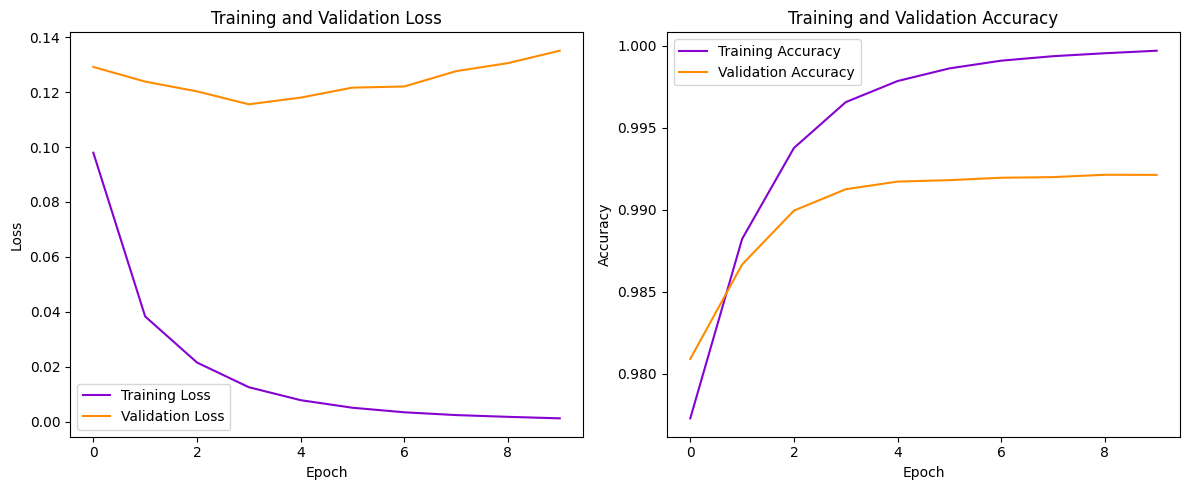

In [26]:
import matplotlib.pyplot as plt

# Plot both loss and accuracy in the same image
plt.figure(figsize=(12, 5))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss',color='#8502d1')
plt.plot(history.history['val_loss'], label='Validation Loss', color='darkorange')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy',color='#8502d1')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy',color='darkorange')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [30]:
# Define a function to preprocess and predict a single sentence
def predict_sentence(sentence, word2idx, max_len, model, tag2idx):
    # Tokenize and pad the sentence
    tokenized_sentence = [word2idx.get(word.lower(), 0) for word in sentence.split()]
    padded_sentence = pad_sequences([tokenized_sentence], maxlen=max_len, padding="post", value=0)
    
    # Make predictions
    predictions = model.predict(padded_sentence)
    
    # Convert predictions to tag indices
    predicted_indices = predictions.argmax(axis=-1)
    
    # Create idx2tag from tag2idx
    idx2tag = {idx: tag for tag, idx in tag2idx.items()}
    
    # Convert predicted indices back to tags using the inverse of tag2idx
    predicted_tags = [idx2tag[idx] for idx in predicted_indices[0]]
    
    return predicted_tags

# Example sentence
sentence = "The European Union is headquartered in Brussels."

# Predict tags for the sentence
predicted_tags = predict_sentence(sentence, word2idx, max_len, model, tag2idx)

# Print the predicted tags
print("Predicted tags:", predicted_tags)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Predicted tags: ['O', 'B-ORG', 'I-ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


In [34]:
y_pred=model.predict(X_test)

108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


In [42]:
y_true=np.array(y_test)

In [62]:
from sklearn.metrics import classification_report
idx2tag = {idx: tag for tag, idx in tag2idx.items()}

# Make predictions on the test data
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)
y_true = np.argmax(y_test, axis=-1)

# Convert indices back to labels
y_pred = [[idx2tag[idx] for idx in row] for row in y_pred]
y_true = [[idx2tag[idx] for idx in row] for row in y_true]

# Flatten the lists
y_pred_flat = [tag for sentence in y_pred for tag in sentence]
y_true_flat = [tag for sentence in y_true for tag in sentence]

# Print the classification report
print(classification_report(y_true_flat, y_pred_flat))



108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
              precision    recall  f1-score   support

       B-LOC       0.85      0.81      0.83      1667
      B-MISC       0.80      0.65      0.72       702
       B-ORG       0.84      0.57      0.68      1660
       B-PER       0.93      0.44      0.60      1616
       I-LOC       0.79      0.65      0.71       257
      I-MISC       0.59      0.42      0.49       216
       I-ORG       0.74      0.49      0.59       835
       I-PER       0.94      0.23      0.38      1155
           O       0.99      1.00      1.00    382081

    accuracy                           0.99    390189
   macro avg       0.83      0.59      0.67    390189
weighted avg       0.99      0.99      0.99    390189



In [65]:
model2 = Sequential()
model2.add(Embedding(input_dim=len(word2idx) + 1, output_dim=50, input_length=max_len))
model2.add(Bidirectional(LSTM(units=128, return_sequences=True)))
model2.add(TimeDistributed((Dense(units=len(tag2idx), activation='softmax'))))
model2.build(input_shape=(None, max_len))
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:86: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [66]:
model2.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (None, 113, 50)        │     1,050,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 113, 256)       │       183,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 113, 9)         │         2,313 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,236,109 (4.72 MB)

 Trainable params: 1,236,109 (4.72 MB)

 Non-trainable params: 0 (0.00 B)

In [67]:
# Train the model
history2=model2.fit(X_train, np.array(y_train), validation_data=(X_valid, np.array(y_valid)), batch_size=32, epochs=10)

# Evaluate the model on test data
loss, accuracy = model2.evaluate(X_test, np.array(y_test))
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

Epoch 1/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 21s 29ms/step - accuracy: 0.9644 - loss: 0.1889 - val_accuracy: 0.9822 - val_loss: 0.1226
Epoch 2/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - accuracy: 0.9877 - loss: 0.0400 - val_accuracy: 0.9870 - val_loss: 0.1045
Epoch 3/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - accuracy: 0.9932 - loss: 0.0229 - val_accuracy: 0.9904 - val_loss: 0.0938
Epoch 4/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - accuracy: 0.9966 - loss: 0.0128 - val_accuracy: 0.9913 - val_loss: 0.0911
Epoch 5/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - accuracy: 0.9980 - loss: 0.0074 - val_accuracy: 0.9917 - val_loss: 0.0905
Epoch 6/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - accuracy: 0.9987 - loss: 0.0049 - val_accuracy: 0.9919 - val_loss: 0.0897
Epoch 7/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - accuracy: 0.9991 - loss: 0.0032 - val_accuracy: 0.9920 - val_loss: 0.0895
Epoch 8/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - accuracy: 0.9994 - loss: 0.0024 - 

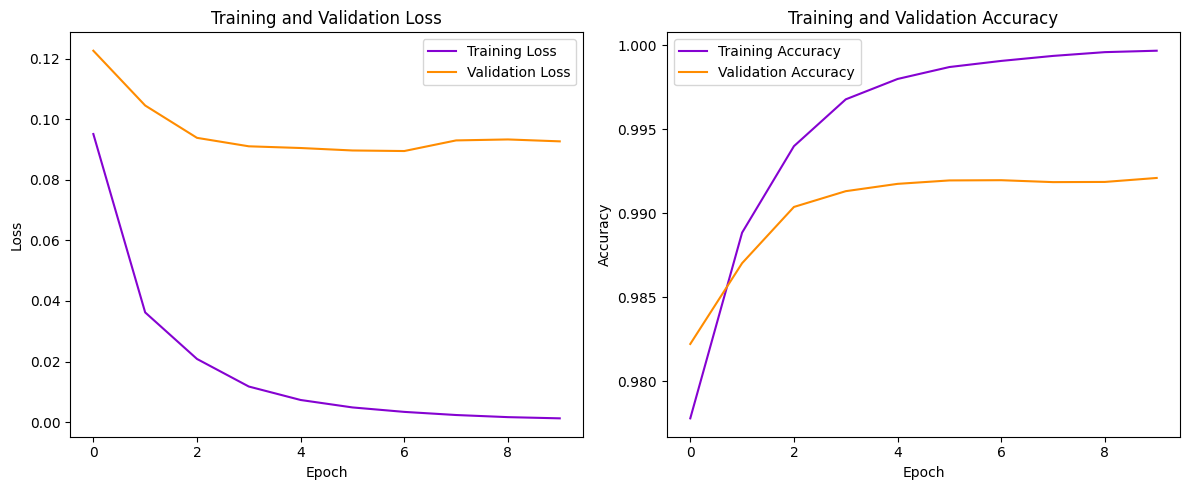

In [68]:
# Plot both loss and accuracy in the same image
plt.figure(figsize=(12, 5))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(history2.history['loss'], label='Training Loss',color='#8502d1')
plt.plot(history2.history['val_loss'], label='Validation Loss', color='darkorange')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history2.history['accuracy'], label='Training Accuracy',color='#8502d1')
plt.plot(history2.history['val_accuracy'], label='Validation Accuracy',color='darkorange')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [69]:
y_pred=model2.predict(X_test)
# Make predictions on the test data
y_pred = np.argmax(y_pred, axis=-1)
y_true = np.argmax(y_test, axis=-1)

# Convert indices back to labels
y_pred = [[idx2tag[idx] for idx in row] for row in y_pred]
y_true = [[idx2tag[idx] for idx in row] for row in y_true]

# Flatten the lists
y_pred_flat = [tag for sentence in y_pred for tag in sentence]
y_true_flat = [tag for sentence in y_true for tag in sentence]

# Print the classification report
print(classification_report(y_true_flat, y_pred_flat))


108/108 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step
              precision    recall  f1-score   support

       B-LOC       0.88      0.81      0.84      1667
      B-MISC       0.77      0.67      0.71       702
       B-ORG       0.85      0.57      0.69      1660
       B-PER       0.91      0.47      0.62      1616
       I-LOC       0.81      0.65      0.72       257
      I-MISC       0.64      0.34      0.45       216
       I-ORG       0.78      0.46      0.58       835
       I-PER       0.92      0.24      0.38      1155
           O       0.99      1.00      1.00    382081

    accuracy                           0.99    390189
   macro avg       0.84      0.58      0.66    390189
weighted avg       0.99      0.99      0.99    390189



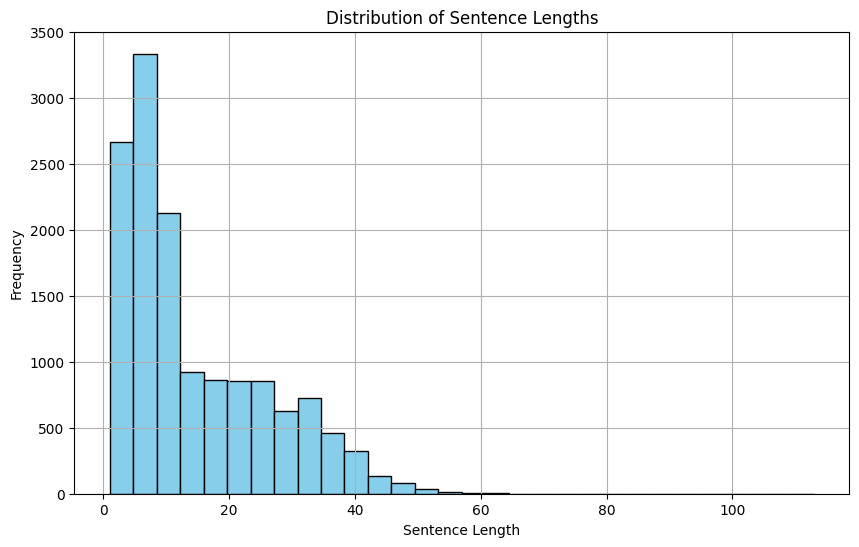

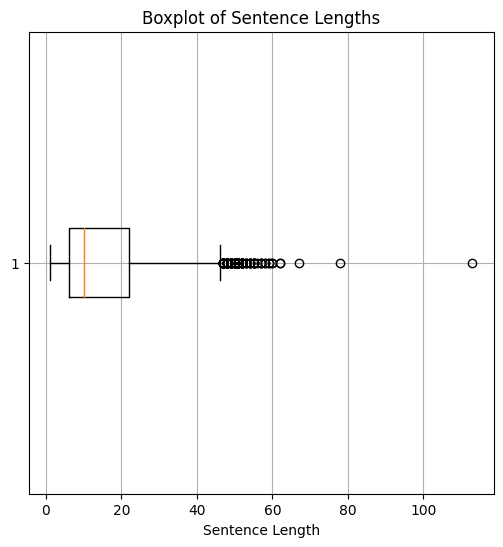

In [72]:
import matplotlib.pyplot as plt

# Calculate the length of each sentence
sentence_lengths = [len(sentence) for sentence in train_sentences]

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(sentence_lengths, bins=30, color='skyblue', edgecolor='black')
plt.xlabel('Sentence Length')
plt.ylabel('Frequency')
plt.title('Distribution of Sentence Lengths')
plt.grid(True)
plt.show()

# Plot boxplot
plt.figure(figsize=(6, 6))
plt.boxplot(sentence_lengths, vert=False)
plt.xlabel('Sentence Length')
plt.title('Boxplot of Sentence Lengths')
plt.grid(True)
plt.show()
